3D slicc preprocessing

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage.filters import median

In [4]:
def evaluate_segmentation(seg_hat_flat, seg_flat, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(seg_flat!=0)

    yhat_coors = np.argwhere(seg_hat_flat ==tumor_label)

    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    total_size = len(seg_flat)
    non_tumor_size = total_size-tumor_size


    #true positive
    correct_id_tumor = np.intersect1d(y_coors, yhat_coors)

    
    
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(yhat_coors, y_coors)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, yhat_coors)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(total_size-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/total_size
    
    #percentage of yhat that is correct
    yhat_size = len(yhat_coors)
    correct_id_tumor_hat = np.intersect1d(yhat_coors, y_coors)
    specificity = len(correct_id_tumor_hat)/yhat_size
    
    #New metric, TP + specificity
    metric = (percent_tumor_correct + specificity)/2
    
    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    print("'specificity':", specificity)
    print("metric: ", metric)
    
    print("************")
    print("Total Error: ", total_error)

# Replicate example from docs
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_mask_slic.html#sphx-glr-auto-examples-segmentation-plot-mask-slic-py


In [5]:
from skimage import data
img = data.immunohistochemistry()
img.shape



(512, 512, 3)

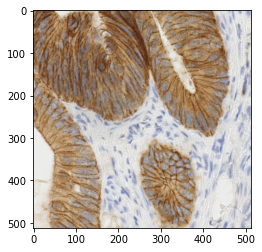

In [6]:
plt.figure()
plt.imshow(img)
plt.show()

In [7]:
slic = skimage.segmentation.slic(img, n_segments=200, start_label=1)
slic.shape

(512, 512)

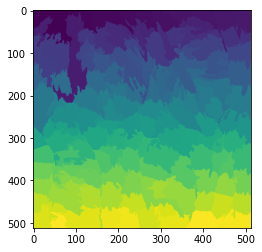

In [8]:
plt.figure()
plt.imshow(slic)
plt.show()

In [9]:
boundary_img = skimage.segmentation.mark_boundaries(img, slic)

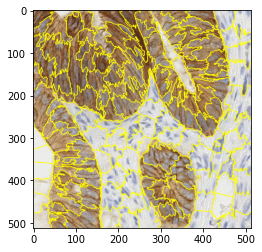

In [10]:
plt.figure()
plt.imshow(boundary_img)
plt.show()

# Load MRI data

In [11]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [12]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [13]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)

Basic preprocessing, need RGB for slicc to work

In [14]:
#FOR NOW, CAST AS ARRAY OF INTS (PROBABLY WANT FLOAT32 EVENTUALLY)
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)
np.min(flair_norm )

0.0

In [15]:
flair_norm  = median(flair_norm )

In [16]:
#convert to rGB color space
flair_rgb = gray2rgb(flair_norm )
flair_rgb.shape

(240, 240, 155, 3)

#### Segment 2D slice using superpixels

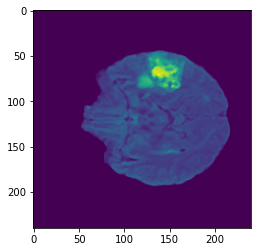

In [17]:
plt.figure()
plt.imshow(flair_rgb[:,:,60,0])
plt.show()

In [18]:
test_2d = flair_rgb[:,:,60,:]
test_2d.shape

(240, 240, 3)

In [19]:
n_segments_2d = 300
slic_2d = skimage.segmentation.slic(test_2d, n_segments=n_segments_2d, start_label=1)
slic_2d.shape

(240, 240)

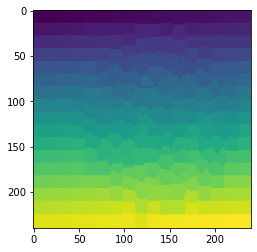

In [20]:
plt.figure()
plt.imshow(slic_2d)
plt.show()

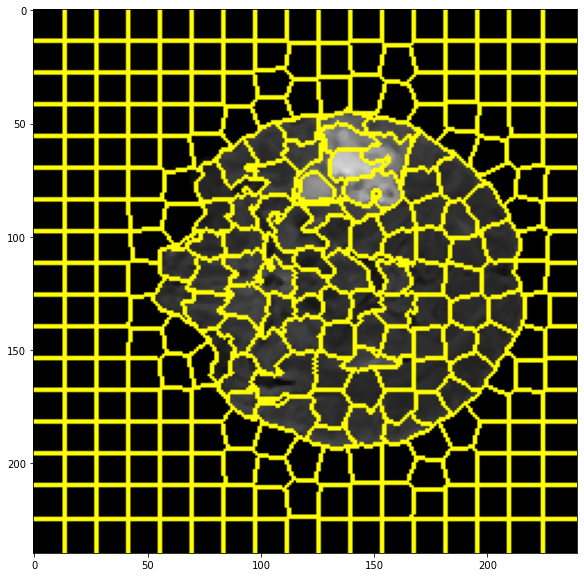

In [21]:
boundary_img = skimage.segmentation.mark_boundaries(test_2d, slic_2d)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img)
plt.show()

#### Can we find a threshold that divides tumor from nontumor?

In [22]:
from skimage.color import rgb2gray
test_2d_gray = rgb2gray(test_2d)

In [23]:
test_2d_gray.shape

(240, 240)

In [24]:
slic_2d.shape

(240, 240)

Go through each label in slic segmentation, cluster image

In [25]:
labels2D = np.unique(slic_2d)
labels2D

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [26]:
slic_cluster_2d =test_2d_gray.copy()
for label in labels2D:
    slic_cluster_2d[slic_2d==label]=np.average(slic_cluster_2d[slic_2d==label])

    

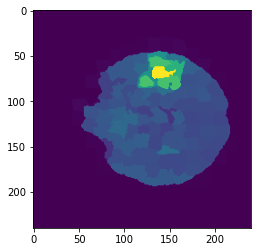

In [27]:
plt.figure()
plt.imshow(slic_cluster_2d)
plt.show()

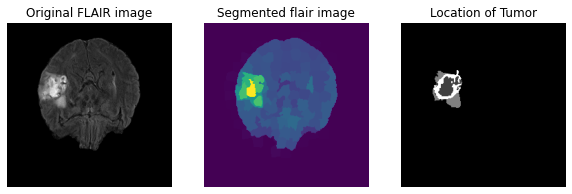

In [28]:

plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(slic_cluster_2d.T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(data_seg[:,:,60].T, cmap="gray", origin='lower')
plt.show()

In [29]:
#normalize
minval = np.min(slic_cluster_2d)
maxval = np.max(slic_cluster_2d)
cluster_2d_norm = (slic_cluster_2d-minval)/(maxval-minval)
np.min(cluster_2d_norm)

0.0

In [30]:
cluster_2d_norm.shape

(240, 240)

In [31]:
slic_cluster_2d.shape

(240, 240)

In [32]:
cluster_2d_masked = cluster_2d_norm[cluster_2d_norm > 0]

In [33]:
np.min(cluster_2d_masked)

0.0002711604916646634

Cut bottom chunk

In [34]:
cluster_2d_masked = cluster_2d_norm[cluster_2d_norm > 0.1]
cluster_2d_masked.shape

(17708,)

Look at histogram , high values sparse

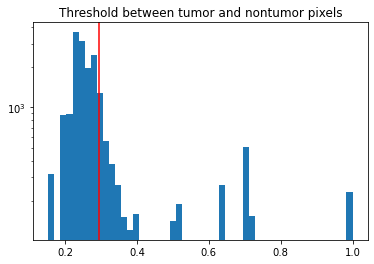

In [35]:

plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_2d_masked.flatten(), bins=50, log=True)
plt.axvline(x=0.295, color="red")
plt.show()

Try otsu thresholding

In [36]:

thresh_2d = threshold_otsu(cluster_2d_masked)
thresh_2d

0.39259442599930944

In [37]:
seg_hat_2d_otsu = cluster_2d_norm.copy()
seg_hat_2d_otsu [cluster_2d_norm<thresh_2d]=0

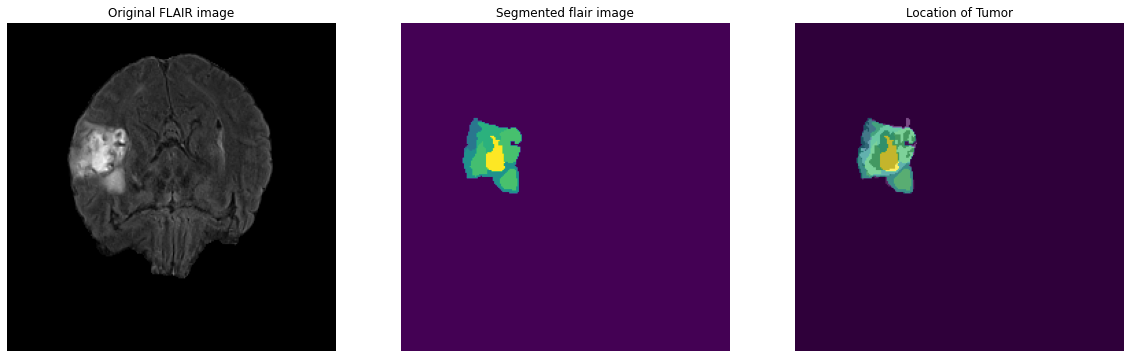

In [38]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(seg_hat_2d_otsu.T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(seg_hat_2d_otsu.T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [39]:
tumor_otsu_label = 1
seg_hat_2d_otsu[seg_hat_2d_otsu>0]=tumor_otsu_label

In [40]:
predicted = seg_hat_2d_otsu.flatten()
actual = (data_seg[:,:,60]).flatten()
evaluate_segmentation(predicted, actual, tumor_otsu_label)

True Positive:  0.9459459459459459
False negative:  0.05405405405405406
True Negative:  0.9987306695271297
False Positive:  0.0012693304728702958
'specificity': 0.956865127582017
metric:  0.9514055367639815
************
Total Error:  0.0027951388888888887


# Segment whole MRI using 2D superpixel slices

In [41]:
1e0

1.0

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


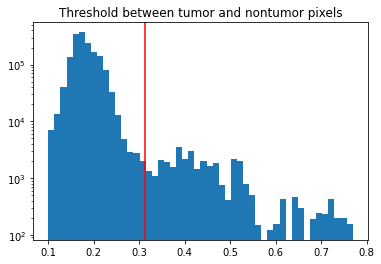

In [44]:
output = np.zeros(data_flair.shape)
for i in range(0, 155):
    print(i)
    slice_2d = flair_rgb[:,:,i,:]
    maxval = np.max(slice_2d)
    if maxval > 0.1: #otherwise assume image has no tumor
        n_segments_2d = 300
        slic_mask_2d = skimage.segmentation.slic(slice_2d, n_segments=n_segments_2d, start_label=1)
        slice_2d = rgb2gray(slice_2d)
        labels2D = np.unique(slic_mask_2d)
        

        for label in labels2D:
            slice_2d[slic_mask_2d ==label]=np.average(slice_2d[slic_mask_2d ==label])
        output[:,:,i]=slice_2d

         

cluster_3d_masked = output[output > 0.1]

thresh_3d = threshold_otsu(cluster_3d_masked)
plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(cluster_3d_masked.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()



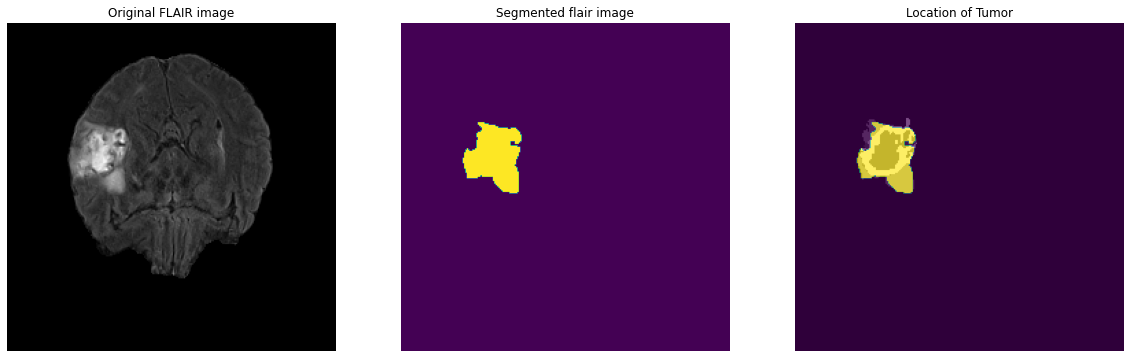

In [45]:
output[output< thresh_3d]=0
tumor_otsu_label = 1
output[output>0]=tumor_otsu_label


plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(output[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(output[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [46]:

evaluate_segmentation(output.flatten(), data_seg.flatten(), tumor_otsu_label)

True Positive:  0.7430667712611324
False negative:  0.2569332287388676
True Negative:  0.9998539054626526
False Positive:  0.00014609453734741395
'specificity': 0.9612583572110793
metric:  0.8521625642361059
************
Total Error:  0.0013926971326164875


# Segment whole MRI using superpixels

In [328]:
#normalize:
minval = np.min(data_flair)
maxval = np.max(data_flair)
flair_norm = (data_flair-minval)/(maxval-minval)
np.min(flair_norm )


0.0

In [329]:
np.max(flair_norm)

1.0

In [350]:
flair_norm[flair_norm <0.05]=0

In [351]:
flair_mask = flair_norm >0
flair_mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [352]:
flair_rgb_norm =gray2rgb(flair_norm) 

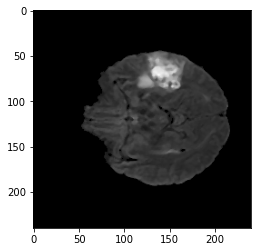

In [353]:
plt.figure()
plt.imshow(flair_rgb_norm[:,:,60])
plt.show()

In [382]:
slic_3d = skimage.segmentation.slic(flair_rgb, n_segments=2000, mask= flair_mask, start_label=1)

In [383]:
slic_3d.shape

(240, 240, 155)

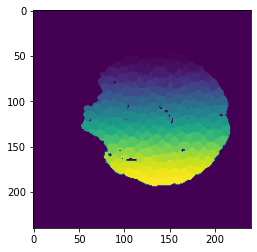

In [384]:
plt.figure()
plt.imshow(slic_3d[:,:,60])
plt.show()

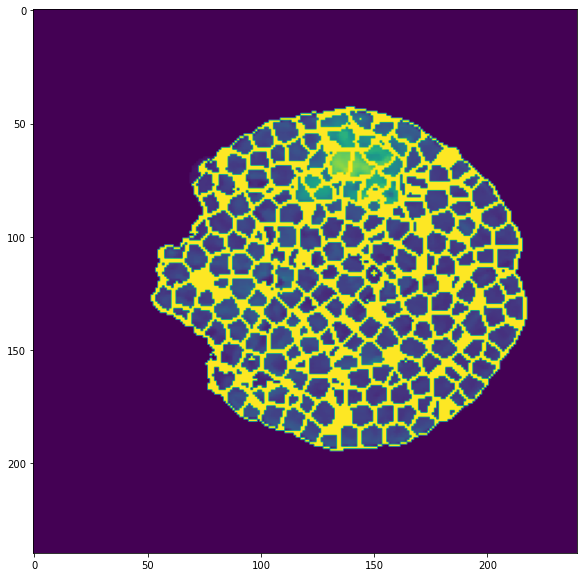

In [385]:
boundary_img = skimage.segmentation.mark_boundaries(flair_rgb, slic_3d)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img[:,:,60,0])
plt.show()

#### Find discrimination boundary

In [386]:
from skimage.color import rgb2gray
slic_cluster_3d = rgb2gray(flair_rgb)

In [387]:
labels3D = np.unique(slic_3d)
labels3D

array([   0,    1,    2, ..., 1997, 1998, 1999])

In [388]:

for label in labels3D:
    slic_cluster_3d[slic_3d==label]=np.average(slic_cluster_3d[slic_3d==label])

    

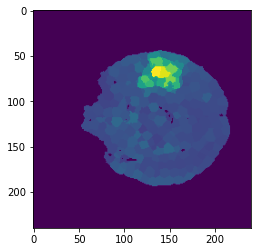

In [389]:
plt.figure()
plt.imshow(slic_cluster_3d[:,:,60])
plt.show()

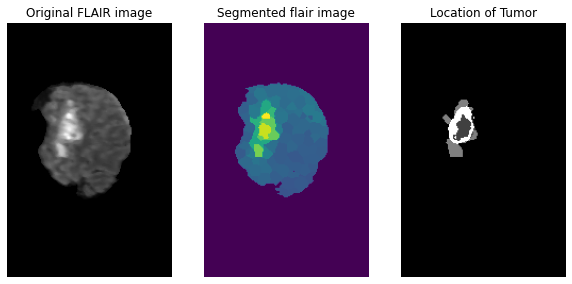

In [415]:

plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[60,:,:], cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(slic_cluster_3d[60,:,:],  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(data_seg[60,:,:], cmap="gray", origin='lower')
plt.show()

Test otsu

In [405]:
thresh_3d = threshold_otsu(slic_cluster_3d[slic_cluster_3d>.1])
thresh_3d

0.2981581498265986

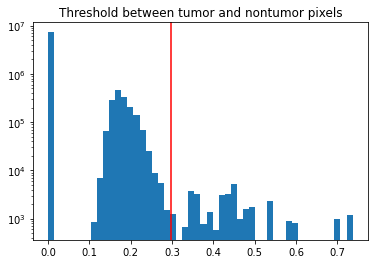

In [406]:

plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(slic_cluster_3d.flatten(), bins=50, log=True)
plt.axvline(x=thresh_3d, color="red")
plt.show()

In [407]:
np.unique(slic_cluster_3d)

array([4.88738415e-04, 1.18136306e-01, 1.21327167e-01, ...,
       5.93093296e-01, 7.01849853e-01, 7.36734856e-01])

In [408]:
seg_hat_3d=slic_cluster_3d.copy()
seg_hat_3d[slic_cluster_3d <thresh_3d]=0

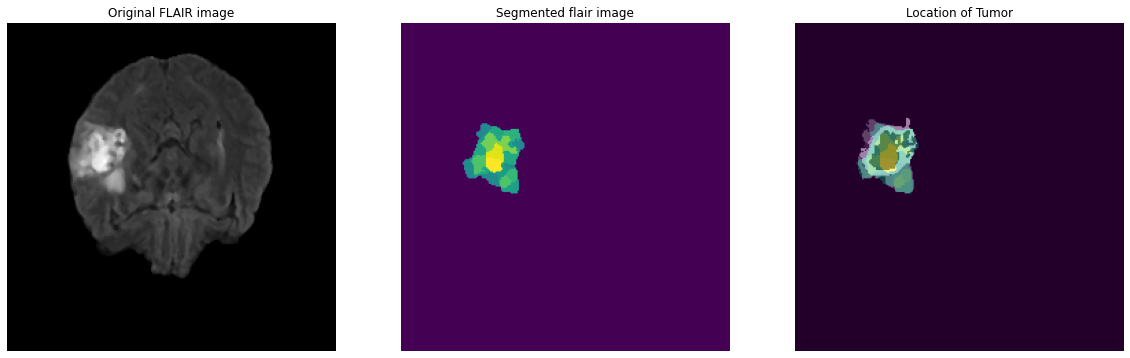

In [409]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(seg_hat_3d[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(seg_hat_3d[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.5, cmap="gray", origin='lower')

plt.show()

In [410]:
otsu_3d_label = 1
seg_hat_3d[seg_hat_3d>0]=otsu_3d_label
otsu_3d_label

1

In [411]:

evaluate_segmentation(seg_hat_3d.flatten(), data_seg.flatten(), otsu_3d_label)

True Positive:  0.733099533939366
False negative:  0.266900466060634
True Negative:  0.9999098445882779
False Positive:  9.015541172209443e-05
'specificity': 0.9754105909439754
metric:  0.8542550624416707
************
Total Error:  0.0013854166666666667
